# Plaque-Mitochondria Spatial Analysis

This notebook performs spatial correlation analysis between amyloid plaques and mitochondrial calcium events in 3D brain tissue imaging data.

## Analysis Overview
1. **Plaque Segmentation**: 3D segmentation and filtering of amyloid plaques
2. **Mitochondrial Event Processing**: Extraction of ROI centroids and event classification
3. **Spatial Analysis**: Distance calculations and spatial relationship analysis
4. **Visualization**: 3D visualization of spatial relationships
5. **Statistical Analysis**: Correlation analysis between coupling fidelity and distance

In [1]:
# Import required libraries
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import os
import scipy.io
import h5py
from scipy.io import savemat
import glob

# Set file paths
input_plaque_tif = './plaque.tif'  # 3D plaque channel TIFF file
mito_input_dir = './mito_events'   # Directory containing mitochondrial events data

print("Libraries imported successfully")
print(f"Plaque file: {input_plaque_tif}")
print(f"Mito events directory: {mito_input_dir}")

Libraries imported successfully
Plaque file: ./plaque.tif
Mito events directory: ./mito_events


## 1. Plaque Segmentation and Analysis

This section performs 3D segmentation of amyloid plaques from the TIFF image stack, applies morphological operations to improve segmentation quality, and extracts centroid coordinates and volumes for each plaque.

In [2]:
# Load 3D plaque TIFF data
print("Loading plaque TIFF data...")
with tf.TiffFile(input_plaque_tif) as tif:
    images = tif.asarray()

print(f"Image shape: {images.shape}")
print(f"Data type: {images.dtype}")
print(f"Value range: [{images.min()}, {images.max()}]")

# Apply Otsu thresholding for initial segmentation
print("\nApplying Otsu thresholding...")
thresh = threshold_otsu(images)
binary_images = images > thresh
print(f"Threshold value: {thresh}")
print(f"Binary image sum: {np.sum(binary_images)} voxels")

# Apply 3D morphological closing to improve segmentation
# Use spherical structuring element for 3D operations
print("\nApplying morphological closing...")
binary_images_closed = binary_closing(binary_images, ball(5))
print(f"After closing - sum: {np.sum(binary_images_closed)} voxels")

# Label connected components in 3D
print("\nLabeling connected components...")
labeled_images, num_features = label(binary_images_closed, connectivity=3, return_num=True)
props = regionprops(labeled_images)

print(f"Identified 3D objects: {num_features}")

# Extract information for all plaques
print("\nExtracting plaque information...")
all_blobs_info = []

for i, prop in enumerate(props):
    # Get centroid coordinates and volume (area in 3D represents volume)
    centroid_3D = prop.centroid  # Returns (z, y, x) format
    volume = prop.area  # In 3D, area represents volume in voxels
    
    blob_info = {
        "id": i + 1,
        "3D_centroid_z": centroid_3D[0],
        "3D_centroid_y": centroid_3D[1],
        "3D_centroid_x": centroid_3D[2],
        "volume": volume
    }
    all_blobs_info.append(blob_info)

# Display all plaque information
print("\nAll identified plaques:")
for blob in all_blobs_info:
    print(f"Plaque {blob['id']}: Centroid (Z, Y, X) = ({blob['3D_centroid_z']:.1f}, {blob['3D_centroid_y']:.1f}, {blob['3D_centroid_x']:.1f}), Volume = {blob['volume']} voxels")

# Filter plaques by volume threshold (remove small artifacts)
volume_threshold = 50
filtered_props = [prop for prop in props if prop.area >= volume_threshold]
filtered_blobs_info = [{
    "id": i + 1,
    "3D_centroid_z": prop.centroid[0],
    "3D_centroid_y": prop.centroid[1],
    "3D_centroid_x": prop.centroid[2],
    "volume": prop.area
} for i, prop in enumerate(filtered_props)]

print(f"\nAfter filtering (volume >= {volume_threshold}):")
print(f"Filtered plaques: {len(filtered_blobs_info)}")
for blob in filtered_blobs_info:
    print(f"Plaque {blob['id']}: Centroid (Z, Y, X) = ({blob['3D_centroid_z']:.1f}, {blob['3D_centroid_y']:.1f}, {blob['3D_centroid_x']:.1f}), Volume = {blob['volume']} voxels")

Loading plaque TIFF data...
Image shape: (141, 440, 512)
Data type: uint16
Value range: [7863, 9711]

Applying Otsu thresholding...
Threshold value: 8171
Binary image sum: 17421 voxels

Applying morphological closing...
After closing - sum: 20515 voxels

Labeling connected components...
Identified 3D objects: 7

Extracting plaque information...

All identified plaques:
Plaque 1: Centroid (Z, Y, X) = (1.2, 126.6, 389.2), Volume = 5.0 voxels
Plaque 2: Centroid (Z, Y, X) = (0.4, 249.1, 322.0), Volume = 10.0 voxels
Plaque 3: Centroid (Z, Y, X) = (0.2, 358.5, 76.5), Volume = 4.0 voxels
Plaque 4: Centroid (Z, Y, X) = (0.8, 382.9, 228.6), Volume = 36.0 voxels
Plaque 5: Centroid (Z, Y, X) = (5.0, 3.0, 276.0), Volume = 1.0 voxels
Plaque 6: Centroid (Z, Y, X) = (21.6, 190.5, 120.7), Volume = 4554.0 voxels
Plaque 7: Centroid (Z, Y, X) = (31.3, 215.1, 376.4), Volume = 15905.0 voxels

After filtering (volume >= 50):
Filtered plaques: 2
Plaque 1: Centroid (Z, Y, X) = (21.6, 190.5, 120.7), Volume = 4

## 2. Mitochondrial Event Processing

This section extracts mitochondrial ROI centroids and classifies events into different categories (all mitochondria, calcium events, coupling events).

In [3]:
def get_data_from_reference(ref, file, field):
    """Helper function to extract data from reference object in MAT file"""
    ref_data = file[ref]
    # Squeeze to remove single-dimensional entries
    data = np.array(ref_data[field]).squeeze()
    return data

print("Loading mitochondrial event data...")

# Load coupling event indicators
with h5py.File(f'{mito_input_dir}/has_coupling.mat', 'r') as file:
    has_coupling = np.array(file['has_coupling']).flatten()
    
print(f"Total mitochondrial events: {len(has_coupling)}")
print(f"Coupling events: {np.sum(has_coupling)}")

# Load mitochondrial statistics
with h5py.File(f'{mito_input_dir}/mito_stat.mat', 'r') as file:
    mito_stat = file['mito_stat']
    refs = file['#refs#']

    # Initialize arrays for storing centroids and points
    mito_centroids = []
    mito_points_x, mito_points_y = [], []

    print("\nExtracting all mitochondrial ROI centroids...")
    # Extract centroids for all mitochondrial events
    for idx in range(mito_stat.shape[0]):
        # Extract pixel coordinates from structure
        struct_ref = mito_stat[idx, 0]
        x_coords = get_data_from_reference(struct_ref, refs, 'xpix')
        y_coords = get_data_from_reference(struct_ref, refs, 'ypix')
        
        # Store all pixel points
        mito_points_x.extend(list(x_coords))
        mito_points_y.extend(list(y_coords))

        # Calculate ROI centroid
        mito_centroid_x_2d = np.mean(x_coords)
        mito_centroid_y_2d = np.mean(y_coords)
        mito_centroids.append([mito_centroid_x_2d, mito_centroid_y_2d])

    mito_centroids = np.array(mito_centroids)
    print(f"Extracted {len(mito_centroids)} mitochondrial centroids")

    # Extract centroids for coupling events only
    print("\nExtracting coupling event centroids...")
    coupling_indices = np.where(has_coupling == 1)[0]
    print(f"Coupling event indices: {coupling_indices}")

    couple_centroids = []
    for idx in coupling_indices:
        struct_ref = mito_stat[idx, 0]
        couple_x_coords = get_data_from_reference(struct_ref, refs, 'xpix')
        couple_y_coords = get_data_from_reference(struct_ref, refs, 'ypix')
        
        # Calculate centroid
        couple_centroid_x_2d = np.mean(couple_x_coords)
        couple_centroid_y_2d = np.mean(couple_y_coords)
        couple_centroids.append([couple_centroid_x_2d, couple_centroid_y_2d])

    couple_centroids = np.array(couple_centroids)
    print(f"Extracted {len(couple_centroids)} coupling event centroids")

    # Extract centroids for calcium events
    print("\nExtracting calcium event centroids...")
    mat_data = scipy.io.loadmat(f'{mito_input_dir}/Label.mat')
    has_calcase = mat_data['predicted_label'].flatten()
    
    calcium_indices = np.where(has_calcase == 2)[0]
    print(f"Calcium event indices: {calcium_indices}")

    calcase_centroids = []
    for idx in calcium_indices:
        struct_ref = mito_stat[idx, 0]
        calcase_x_coords = get_data_from_reference(struct_ref, refs, 'xpix')
        calcase_y_coords = get_data_from_reference(struct_ref, refs, 'ypix')

        # Calculate centroid
        calcase_centroids_x_2d = np.mean(calcase_x_coords)
        calcase_centroids_y_2d = np.mean(calcase_y_coords)
        calcase_centroids.append([calcase_centroids_x_2d, calcase_centroids_y_2d])

    calcase_centroids = np.array(calcase_centroids)
    print(f"Extracted {len(calcase_centroids)} calcium event centroids")

    # Save processed centroids to MAT files
    print("\nSaving processed centroids...")
    savemat(f'{mito_input_dir}/couple_centroids.mat', {'couple_centroids': couple_centroids})
    savemat(f'{mito_input_dir}/calcase_centroids.mat', {'calcase_centroids': calcase_centroids})
    print("Centroids saved successfully")

Loading mitochondrial event data...
Total mitochondrial events: 2521
Coupling events: 14

Extracting all mitochondrial ROI centroids...
Extracted 2521 mitochondrial centroids

Extracting coupling event centroids...
Coupling event indices: [  1   2   3   4   6   9  12  13  36  37  45  95 236 261]
Extracted 14 coupling event centroids

Extracting calcium event centroids...
Calcium event indices: [   0    1    2    3    4    6    9   10   12   13   36   37   40   44
   45   50   52   82   95  116  138  233  236  261  333  479  685  789
  844 1498 1729]
Extracted 31 calcium event centroids

Saving processed centroids...
Centroids saved successfully


## 3. 3D Spatial Visualization

This section creates 3D scatter plots to visualize the spatial relationships between plaques, calcium events, and coupling events.

Creating 3D spatial visualization...


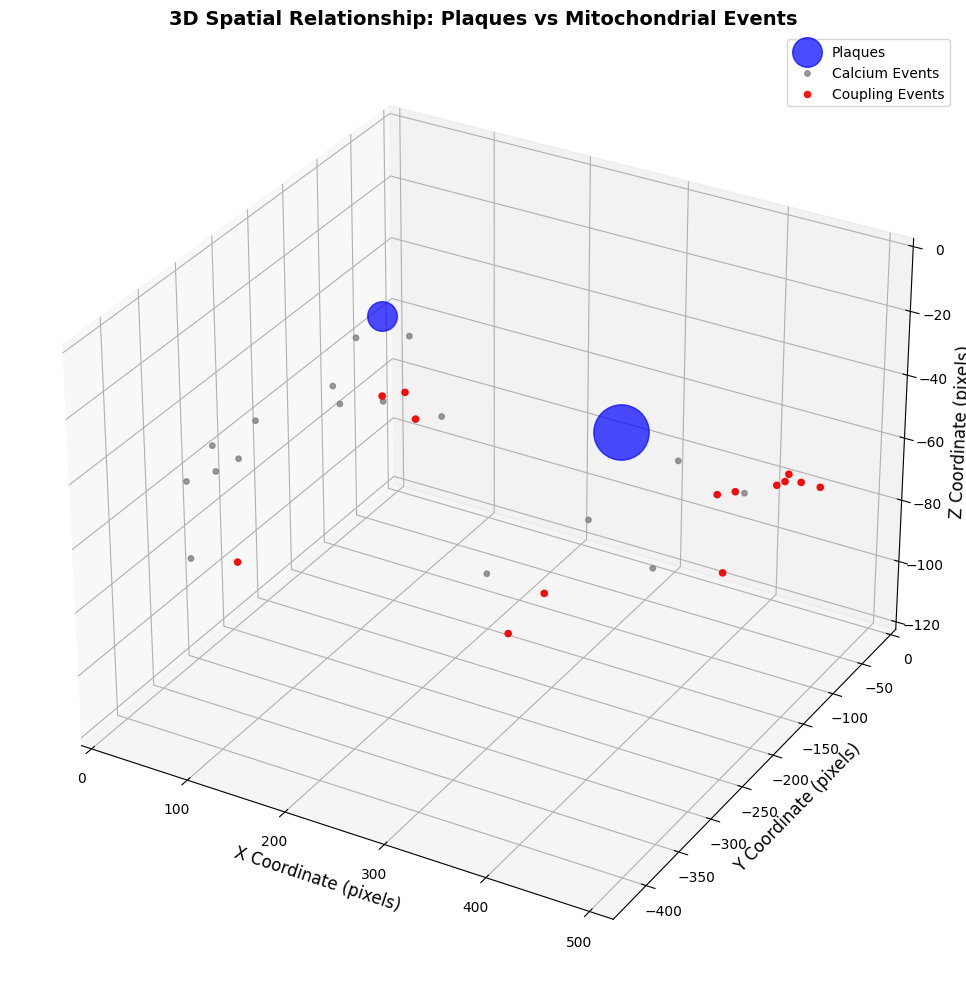

3D visualization completed


In [4]:
# Create 3D visualization of spatial relationships
print("Creating 3D spatial visualization...")

# Create 3D figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D plaque locations
# Use sphere size proportional to volume for better visualization
for blob in filtered_blobs_info:
    # Scale sphere size by volume (divide by 10 for reasonable visualization)
    sphere_size = blob['volume'] / 10
    ax.scatter(blob['3D_centroid_x'], 
              -blob['3D_centroid_y'], 
              -blob['3D_centroid_z'], 
              color='blue', 
              s=sphere_size, 
              alpha=0.7,
              label='Plaques' if blob['id'] == 1 else "")

# Plot calcium events (grey points)
if len(calcase_centroids) > 0:
    # Use Z-axis position from file or default value
    try:
        with open(f'{mito_input_dir}/Z-axis.txt', 'r') as f:
            z_position = int(f.read().strip())
    except:
        z_position = 57  # Default Z position
    
    ax.scatter(calcase_centroids[:, 0], 
              -calcase_centroids[:, 1], 
              -z_position, 
              color='grey', 
              s=15, 
              alpha=0.8,
              label='Calcium Events')

# Plot coupling events (red points)
if len(couple_centroids) > 0:
    ax.scatter(couple_centroids[:, 0], 
              -couple_centroids[:, 1], 
              -z_position, 
              color='red', 
              s=20, 
              alpha=0.9,
              label='Coupling Events')

# Configure plot appearance
ax.set_xlabel('X Coordinate (pixels)', fontsize=12)
ax.set_ylabel('Y Coordinate (pixels)', fontsize=12)
ax.set_zlabel('Z Coordinate (pixels)', fontsize=12)
ax.set_title('3D Spatial Relationship: Plaques vs Mitochondrial Events', fontsize=14, fontweight='bold')

# Invert Y and Z axes to match image coordinate system
ax.invert_yaxis()
ax.invert_zaxis()

# Set axis limits for better visualization
ax.set_xlim([0, 512])
ax.set_ylim([-440, 0])
ax.set_zlim([-120, 0])

# Add legend
ax.legend()

# Add grid for better spatial reference
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("3D visualization completed")

## 4. Distance Analysis and Statistical Correlation

This section calculates the nearest plaque distances for each mitochondrial event and analyzes the correlation between coupling fidelity and spatial proximity to plaques.

In [5]:
def load_z_axis(filepath):
    """Load Z-axis position from text file"""
    with open(filepath, 'r') as file:
        return int(file.read().strip())

def load_mat_centroids(filepath):
    """Load centroid data from MAT file"""
    data = scipy.io.loadmat(filepath)
    return data['couple_centroids']

def load_h5_data(filepath, dataset_name):
    """Load data from HDF5 MAT file"""
    with h5py.File(filepath, 'r') as file:
        return np.array(file[dataset_name]).flatten()

def calculate_nearest_3d_distance_and_ratio(centroids_2d, z_axis, blobs_3d_info, fidelity_data):
    """Calculate nearest plaque distance and distance/volume ratio for each event"""
    distances = []
    ratios = []
    
    for idx, (x, y) in enumerate(centroids_2d):
        min_distance = np.inf
        nearest_volume = 0
        
        # Calculate distance to each plaque
        for blob in blobs_3d_info:
            distance = np.sqrt((blob['3D_centroid_x'] - x)**2 + 
                              (blob['3D_centroid_y'] - y)**2 + 
                              (blob['3D_centroid_z'] - z_axis)**2)
            
            if distance < min_distance:
                min_distance = distance
                nearest_volume = blob['volume']
        
        # Calculate distance/volume ratio
        ratio = min_distance / nearest_volume if nearest_volume > 0 else np.inf
        
        distances.append(min_distance)
        ratios.append(ratio)
    
    return ratios, distances, fidelity_data

print("Performing distance analysis...")

# Load coupling event data for current slice
try:
    centroids = load_mat_centroids(os.path.join(mito_input_dir, 'couple_centroids.mat'))
    z_axis = load_z_axis(os.path.join(mito_input_dir, 'Z-axis.txt'))
    has_coupling = load_h5_data(os.path.join(mito_input_dir, 'has_coupling.mat'), 'has_coupling')
    fidelity = load_h5_data(os.path.join(mito_input_dir, 'fidelity.mat'), 'fidelity')

    # Filter for coupling events only
    coupled_indices = np.where(has_coupling == 1)[0]
    coupled_fidelity = fidelity[coupled_indices]

    print(f"Processing {len(centroids)} coupling events")
    print(f"Z-axis position: {z_axis}")
    
    # Calculate distances and ratios
    ratios, distances, fidelities = calculate_nearest_3d_distance_and_ratio(
        centroids, z_axis, filtered_blobs_info, coupled_fidelity)
    
    print(f"\nDistance analysis results:")
    print(f"Number of events analyzed: {len(distances)}")
    print(f"Distance range: [{min(distances):.2f}, {max(distances):.2f}] pixels")
    print(f"Mean distance: {np.mean(distances):.2f} pixels")
    print(f"Median distance: {np.median(distances):.2f} pixels")
    
    # Display individual distances
    print("\nIndividual event distances:")
    for i, distance in enumerate(distances):
        print(f"Event {i+1}: {distance:.2f} pixels")
    
    # Calculate correlation between fidelity and distance
    if len(fidelities) > 1:
        correlation = np.corrcoef(distances, fidelities)[0, 1]
        print(f"\nCorrelation between distance and fidelity: {correlation:.3f}")
    
    # Classify events as close or distal based on median distance
    median_distance = np.median(distances)
    close_events = [d for d in distances if d <= median_distance]
    distal_events = [d for d in distances if d > median_distance]
    
    print(f"\nSpatial classification (median distance: {median_distance:.2f}):")
    print(f"Close events (≤ median): {len(close_events)}")
    print(f"Distal events (> median): {len(distal_events)}")
    
except Exception as e:
    print(f"Error in distance analysis: {e}")

Performing distance analysis...
Processing 14 coupling events
Z-axis position: 57

Distance analysis results:
Number of events analyzed: 14
Distance range: [46.18, 227.38] pixels
Mean distance: 129.68 pixels
Median distance: 133.95 pixels

Individual event distances:
Event 1: 158.25 pixels
Event 2: 129.95 pixels
Event 3: 227.38 pixels
Event 4: 103.28 pixels
Event 5: 152.55 pixels
Event 6: 46.18 pixels
Event 7: 137.95 pixels
Event 8: 171.90 pixels
Event 9: 88.40 pixels
Event 10: 70.25 pixels
Event 11: 128.83 pixels
Event 12: 65.09 pixels
Event 13: 145.97 pixels
Event 14: 189.48 pixels

Correlation between distance and fidelity: 0.189

Spatial classification (median distance: 133.95):
Close events (≤ median): 7
Distal events (> median): 7


## 5. Summary Statistics and Visualization

This section provides summary statistics and creates additional visualizations to better understand the spatial relationships.

Creating summary visualizations...


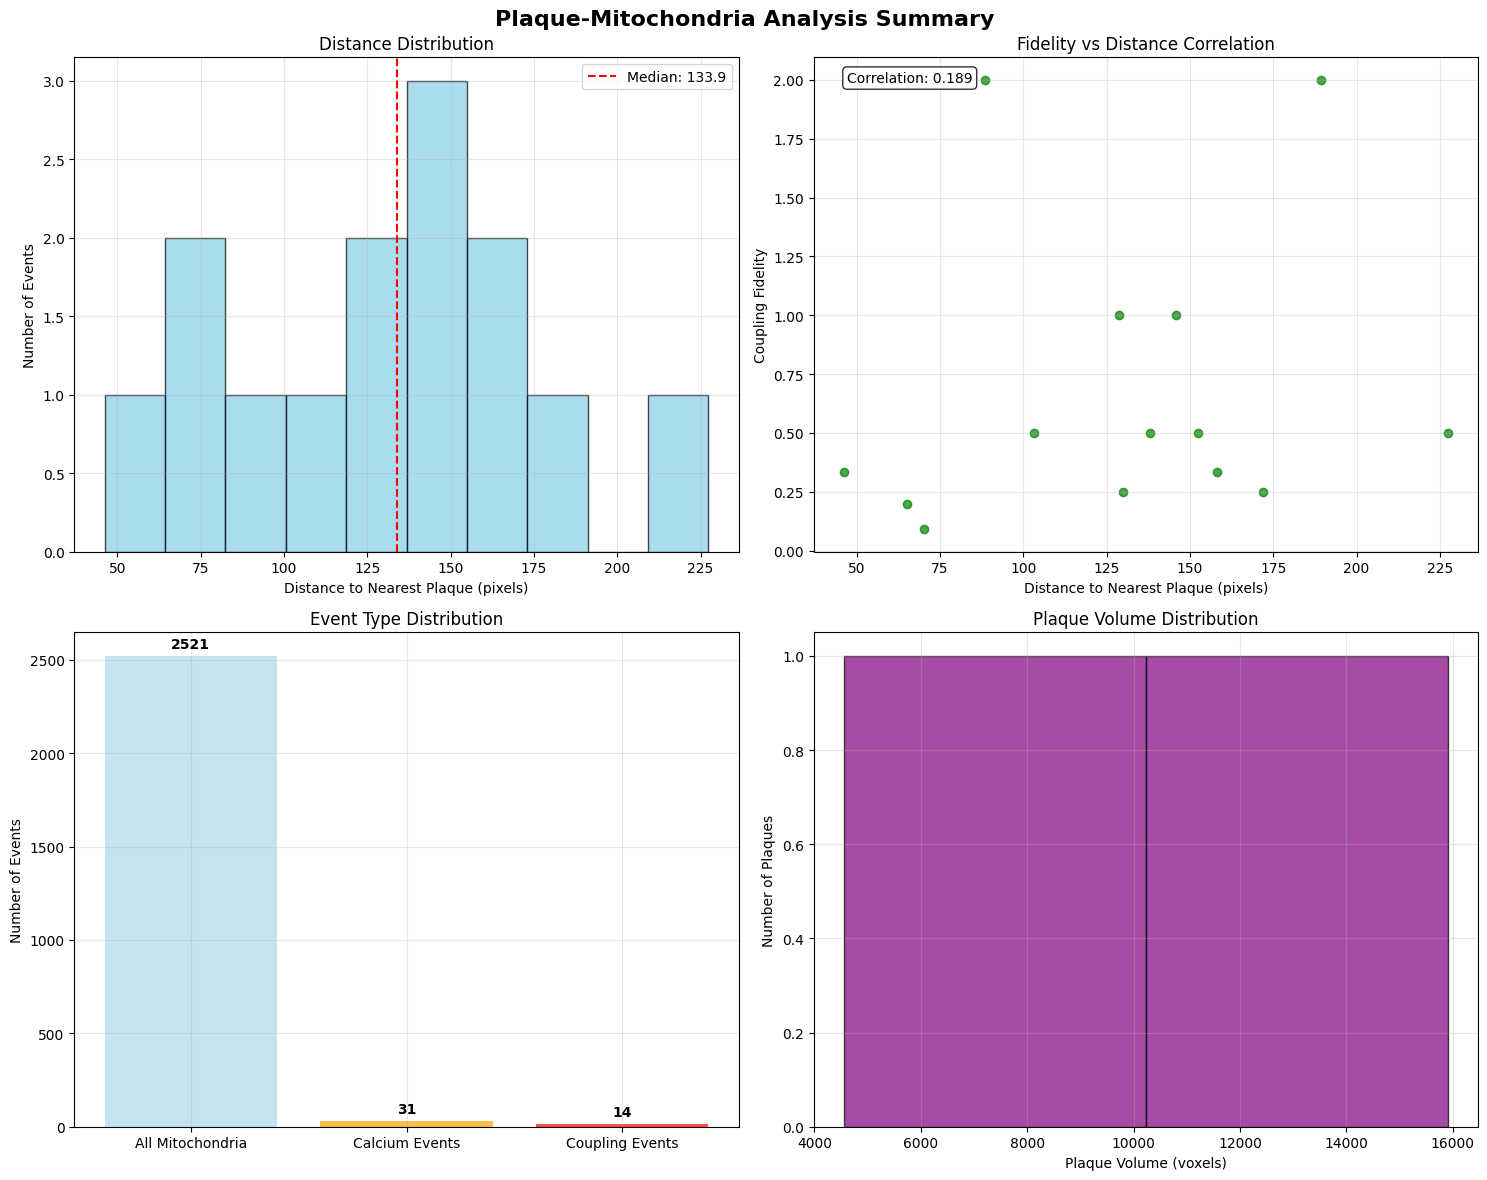


ANALYSIS SUMMARY
Total plaques identified: 7
Filtered plaques (volume ≥ 50): 2
Total mitochondrial events: 2521
Calcium events: 31
Coupling events: 14

Distance Analysis:
  Mean distance: 129.68 pixels
  Median distance: 133.95 pixels
  Distance range: 46.18 - 227.38 pixels
  Fidelity-distance correlation: 0.189

Analysis completed successfully!


In [6]:
# Create summary visualizations
print("Creating summary visualizations...")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Plaque-Mitochondria Analysis Summary', fontsize=16, fontweight='bold')

# 1. Distance distribution histogram
if 'distances' in locals() and len(distances) > 0:
    axes[0, 0].hist(distances, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.median(distances), color='red', linestyle='--', 
                       label=f'Median: {np.median(distances):.1f}')
    axes[0, 0].set_xlabel('Distance to Nearest Plaque (pixels)')
    axes[0, 0].set_ylabel('Number of Events')
    axes[0, 0].set_title('Distance Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Fidelity vs Distance scatter plot
if 'fidelities' in locals() and len(fidelities) > 0:
    axes[0, 1].scatter(distances, fidelities, alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Distance to Nearest Plaque (pixels)')
    axes[0, 1].set_ylabel('Coupling Fidelity')
    axes[0, 1].set_title('Fidelity vs Distance Correlation')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add correlation line if correlation exists
    if 'correlation' in locals():
        axes[0, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                        transform=axes[0, 1].transAxes, 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Event type distribution
event_types = ['All Mitochondria', 'Calcium Events', 'Coupling Events']
event_counts = [len(mito_centroids), len(calcase_centroids), len(couple_centroids)]
colors = ['lightblue', 'orange', 'red']

axes[1, 0].bar(event_types, event_counts, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Number of Events')
axes[1, 0].set_title('Event Type Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, count in enumerate(event_counts):
    axes[1, 0].text(i, count + max(event_counts) * 0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

# 4. Plaque volume distribution
plaque_volumes = [blob['volume'] for blob in filtered_blobs_info]
axes[1, 1].hist(plaque_volumes, bins=len(plaque_volumes), alpha=0.7, 
                color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Plaque Volume (voxels)')
axes[1, 1].set_ylabel('Number of Plaques')
axes[1, 1].set_title('Plaque Volume Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Total plaques identified: {len(all_blobs_info)}")
print(f"Filtered plaques (volume ≥ {volume_threshold}): {len(filtered_blobs_info)}")
print(f"Total mitochondrial events: {len(mito_centroids)}")
print(f"Calcium events: {len(calcase_centroids)}")
print(f"Coupling events: {len(couple_centroids)}")

if 'distances' in locals() and len(distances) > 0:
    print(f"\nDistance Analysis:")
    print(f"  Mean distance: {np.mean(distances):.2f} pixels")
    print(f"  Median distance: {np.median(distances):.2f} pixels")
    print(f"  Distance range: {min(distances):.2f} - {max(distances):.2f} pixels")
    
    if 'correlation' in locals():
        print(f"  Fidelity-distance correlation: {correlation:.3f}")

print("\nAnalysis completed successfully!")